In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Generate some random linear-looking data

Text(0, 0.5, 'y')

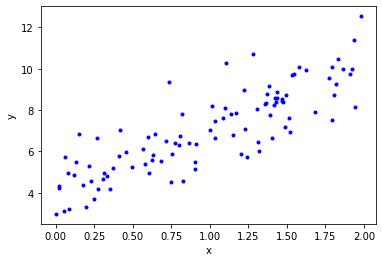

In [3]:
X = 2*np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.plot(X ,y, "b.")
plt.xlabel('x')
plt.ylabel('y')

Fit it with the normal equation $\theta_{best} = (X^T X)^{-1} X^T y$

In [4]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.08883   ],
       [2.98818351]])

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x_0 = 1
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.08883   ],
       [10.06519702]])

Plot the model's prediction

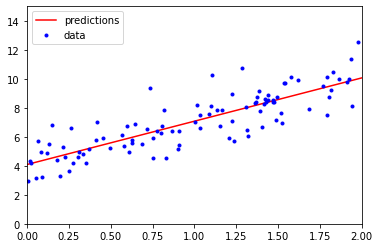

In [6]:
plt.plot(X_new, y_predict, "r-", label="predictions")
plt.plot(X, y, "b.", label="data")
plt.axis([0, 2, 0, 15])
plt.legend()
plt.show()

Do linear regression using scikit-learn.

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.08883]), array([[2.98818351]]))

In [8]:
lin_reg.predict(X_new)

array([[ 4.08883   ],
       [10.06519702]])

Linear regression is based on `numpy.linalg.lstsq()`, i.e. least squares.

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.08883   ],
       [2.98818351]])

Using least squares with `numpy` computes the pseudoinverse, such that $\theta = X^+ y$ where $X^+$ is the pseudoinverse. Compute the pseudoinverse with `np.linalg.pinv()`

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.08883   ],
       [2.98818351]])

Let's do a quick implementation of gradient descent.

In [11]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # random initialization
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.08883   ],
       [2.98818351]])

Let's do a quick implementation of stochastic gradient descent

In [12]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0/(t + t1)

theta = np.random.randn(2, 1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m + i)
        theta = theta - eta * gradients
        
theta

array([[4.09326954],
       [2.93300584]])

Let's do stochastic gradient descent using scikit-learn

In [13]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel()) # ravel flattens an array into 1D
sgd_reg.intercept_, sgd_reg.coef_

(array([4.07200175]), array([3.01271298]))

## Polynomial Regression

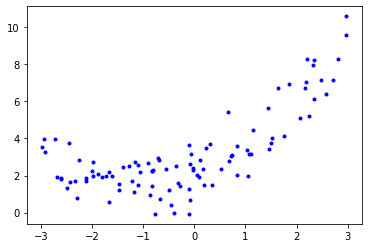

In [14]:
# Polynomial regression
n = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5*X**2. + X + 2 + np.random.randn(m, 1)
plt.plot(X, y, 'b.')

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

[-0.66938035]
[-0.66938035  0.44807006]


(array([2.11665959]), array([[0.99419011, 0.4619673 ]]))

## Learning Curves

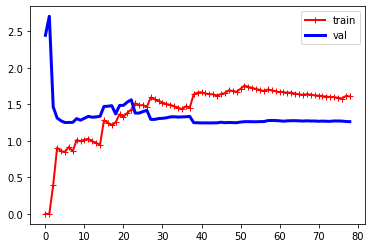

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

These curves are typical of an *underfitting* model

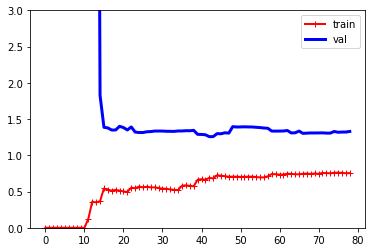

In [17]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.ylim([0,3])
plt.show()

This is typical of *overfitting*. The training error is less than the underfitting linear model, and there is a gap. 

## Regularized Linear Models

### Ridge Regression

Adds a penalty to all weights, $\theta_i$, except the bias term, proportional to $|\theta_i|^2$

In [18]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[4.75219872]])

In [19]:
# Compare with SGD
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.74339083])

### Lasso Regression

Adds a pentaly to all weights, except the bias term, proportional to the L1 norm, $|\theta_i|$

In [20]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.69274155])

### Elastic Net

Adds a penalty which is some fraction, $r$, of L2-norm and $1-r$ fraction of L1-norm.

In [21]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) #l1_ratio corresponds to r above
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.695498])

### Early Stopping

Cf. [Ch. 4 Notebook](https://github.com/ageron/handson-ml/blob/master/04_training_linear_models.ipynb)

In [22]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

# prepare the data
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler() )
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

## Logistic Regression

### Decision Boundaries

In [23]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [24]:
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(np.int) # 1 if Iris-Virginica, else 0

In [25]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

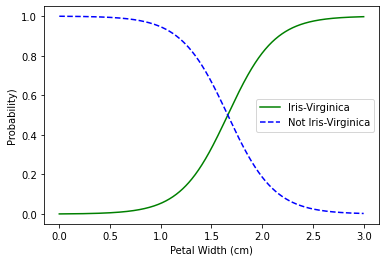

In [26]:
X_new = np.linspace(0, 3, 1000).reshape(-1,1) # -1 infers the size in the 0th dimension
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")
plt.xlabel('Petal Width (cm)')
plt.ylabel('Probability)')
plt.legend()
plt.show()

In [27]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

As an exercise, try to do logistic regression with petal width and length. See [here](https://scikit-learn.org/stable/datasets/toy_dataset.html) for a description. For petal width and length, take columns 3, and 4 of `iris["data"]`

In [28]:
X = iris["data"][:, (2,3)]
y = (iris["target"] == 2).astype(np.int) # 1 if Iris-Virginica, else 0
length = np.linspace(3, 7, 100).reshape(-1, 1)
width = np.linspace(0, 3, 100).reshape(-1, 1)
X0, X1 = np.meshgrid(length, width)
X_new = np.c_[X0.ravel(), X1.ravel()]

In [29]:
log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42) # very little regularization
log_reg.fit(X, y)

LogisticRegression(C=10000000000, random_state=42, solver='liblinear')

In [30]:
log_reg.coef_

array([[ 5.75286199, 10.44454566]])

In [31]:
log_reg.intercept_

array([-45.26057652])

For logistic regression, $p = \sigma(\theta^T x)$, and $p=0.5$ when $\theta^T x = 0$. This is where the decision boundayr occurs. So we plot $\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0 \implies x_2 = -(x_1 \theta_1 + \theta_0)/ \theta_2$ as the decision boundary.

In [32]:
y_proba = log_reg.predict_proba(X_new)
boundary = -(log_reg.coef_[0][0]*np.array([3., 7.]) +  log_reg.intercept_[0])/log_reg.coef_[0][1]

(2.9, 7.0, 0.8, 2.7)

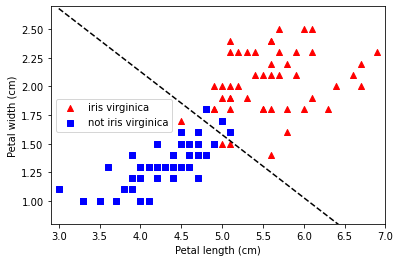

In [33]:
plt.scatter(X[iris["target"] == 2][:,0], X[iris["target"] == 2][:,1], marker = "^", color = "r", label = "iris virginica") # iris virginica
plt.scatter(X[iris["target"] != 2][:,0], X[iris["target"] != 2][:,1], marker = "s", color = "b", label = "not iris virginica")
plt.plot(np.array([3., 7.]), boundary, 'k--')
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.legend()
plt.axis([2.9, 7, 0.8, 2.7])

### Softmax Regression

In [34]:
X = iris["data"][:, (2,3)]
y = (iris["target"])
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [35]:
softmax_reg.predict([[5, 2]])

array([2])

In [36]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

In [37]:
softmax_reg.coef_

array([[-4.58614563, -2.24129385],
       [ 0.16068263, -2.15860167],
       [ 4.425463  ,  4.39989552]])

In [38]:
softmax_reg.intercept_

array([ 18.87514796,   6.3844344 , -25.25958236])

In [39]:
softmax_reg.coef_[1]

array([ 0.16068263, -2.15860167])

For softmax regression, the decision boundary doesn't have a nice easy form like logistic regression, since the equation differs in form (see p. 143 of the book.) So, what I wrote below don't actually represent the decision boundaries. The softmax regression still does give the $\theta$ coefficients, though.

In [40]:
# Three decision boundaries -- WRONG
left_right = np.array([0.0, 7.0])
boundary_0 = -(softmax_reg.coef_[0][0]*left_right +  softmax_reg.intercept_[0])/softmax_reg.coef_[0][1] #setosa/versicolour
boundary_1 = -(softmax_reg.coef_[1][0]*left_right +  softmax_reg.intercept_[1])/softmax_reg.coef_[1][1] #versicolor/virginica
boundary_2 = -(softmax_reg.coef_[2][0]*left_right +  softmax_reg.intercept_[2])/softmax_reg.coef_[2][1] #versicolor/virginica

(0.0, 7.0, 0.0, 3.5)

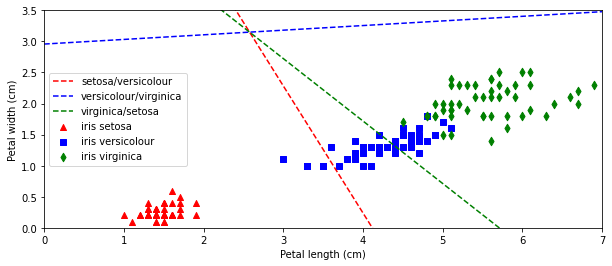

In [41]:
plt.figure(figsize=(10, 4))
plt.scatter(X[iris["target"] == 0][:,0], X[iris["target"] == 0][:,1], marker = "^", color = "r", label = "iris setosa") 
plt.scatter(X[iris["target"] == 1][:,0], X[iris["target"] == 1][:,1], marker = "s", color = "b", label = "iris versicolour")
plt.scatter(X[iris["target"] == 2][:,0], X[iris["target"] == 2][:,1], marker = "d", color = "g", label = "iris virginica")
plt.plot(left_right, boundary_0, 'r--', label = 'setosa/versicolour') # WRONG
plt.plot(left_right, boundary_1, 'b--', label = 'versicolour/virginica') # WRONG
plt.plot(left_right, boundary_2, 'g--', label = 'virginica/setosa') # WRONG
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.legend()
plt.axis([0.0, 7, 0.0, 3.5])


# Exercises

#### 1. What Linear Regression training algorithm can you use if you have a training set with millions of features?

With millions of features, I would *not* use normal equation/SVD. I'd use stochastic gradient descent or mini-batch gradient descent.

#### 2. What algorithms suffer if the features have very different scales? What can you do about it?

Gradient descent algorithms will suffer, as it's stepping towards the local minimum. If one feature is of a much different scale, convergence may be very slow as the cost function is locally flat, and it will take many iterations to get to the minimum. You can use scikit-learn's `StandardScaler`.

#### 3. Can gradient descent get stuck in a local minimum when training a Logistic Regression model?

No, since the cost function is convex.

#### 4. Do all gradient descent algorithms lead to the same model provided they run long enough?

Not necessarily; SGD may find a local minimum but keep walking around it, same with mini-batch GD. Mini-batch GD may have more chances of ending up in a local minimum. If you use mean squared error cost, however, then there are no local minima.

#### 5. You do batch GD, and you notice the validation error is going up with each epoch. What is happening? How do you fix it?
The learning rate might be too high. This could be diagnosed with the training error also increasing. If the validation error goes up, but the training errors remain steady, then this is overfitting, and you have to reduce the number of features.

#### 6. Is it a good idea to stop mini-batch GD immediately when the validation error goes up?
No, since mini-batch GD is only using a subset of the data, so the error might go up before going down.

#### 7. Which GD algorithm will reach the vicinity of the solution the fastest? Which will actually converge? How can you make the others converge?
SGD will reach the vicinity the fastest, while batch GD will converge. To make the others converge, using a learning schedule to decreae the learning rate.

#### 8. Suppose you are using polynomial regression. On the learning curve, there is a gap between training error and validation error. What's happening? How do you fix it?
The gap indicates overfitting; it does well on the training set, but not at all on the validation. To fix overfitting of a polynomial regression, decrease the degree of the polynomial or add some regularization.

#### 9. You're doing ridge regression and you notice the training error and validation errors are approx. equal and high. Is this high bias or high variance? Should you increase the regularization hyperparameter $\alpha$ or decrease it?
This is high bias, and you should decrease $\alpha$, so as not to mute out all the features.

#### 10. Why would you want ot use
##### a. Ridge regression instead of linear regression?
You want to use ridge regression instead of unregularized linear regression when you think only a few features are important.

##### b. Lasso instead of ridge regression?
Lasso regularizes the modulus and not modulus squared of the parameter vector. You'd use this when you want to mute out smaller featues.

##### c. Elastic net instead of lasso?
Elastic net is a mix of ridge and lasso. You'd use this when you think only a few features are important, and like lasso, you want to mute out smaller features. Elastic net is preferable in general to lasso, which can be unstable when the number of features exceeds the number of training examples.

#### 11. If you want to classify pictures as indoor/outdoor and daytime/nighttime should you use two logistic regression classifiers or one softmax regression classifier?
You'd have to use two logistic regression classifiers. Softmax is a multiclass classifier, but not multioutput. It could differentiate between four mutually exclusive classes, but here day/night and in/out are not mutually exclusive, i.e. day doesn't have anything to do with it being in/out.

#### 12. Implement Batch GD with early stopping for the Softmax Regression.

In [83]:
X = iris["data"][:, (2,3)]
y = (iris["target"])
m = X.shape[0] # number of training examples
n = X.shape[1] # number of features

# theta = theta - eta*gradient
iterations = 1000
eta = 0.1

Theta = np.random.rand(3,2) # 3 classes (iris virginica, setosa, or versicolour) and 2 features (length and width)

S = Theta.dot(X.T) # Softmax score
P = np.exp(S) #Numerator of softmax function
N = np.sum(P, axis=0) #Denominator
P = S/N #Softmax Function
Y = np.argmax(P, axis=0)




In [82]:
N = np.array([ [1,2], [3,4]])
M = np.array( [4,5])
Q = N -M
#R = np.sum(Q, axis=0)
print(N)
print(M)
print(Q)
#print(R)

[[1 2]
 [3 4]]
[4 5]
[[-3 -3]
 [-1 -1]]
